In [ ]:
    for index, row in tqdm(batch_df.iterrows(), total=batch_df.shape[0], desc="Processing batch"):
        # Get image paths
        left_fundus_path = os.path.join(image_dir, row['Left-Fundus'])
        right_fundus_path = os.path.join(image_dir, row['Right-Fundus'])

        # Load images
        left_img = load_and_preprocess_image(left_fundus_path, image_size)
        right_img = load_and_preprocess_image(right_fundus_path, image_size)


        # Perform prediction using the diagnoser
        predictions = diagnoser.predict(left_img, right_img, parallel=True) # Use parallel execution

########################################################################################################################################################################################
        # Get image paths (using the correct column names from input df)
        left_fundus_filename = row.get('Left-Fundus', 'unknown.jpg') # Get actual filename
        right_fundus_filename = row.get('Right-Fundus', 'unknown.jpg')# Get actual filename
        left_fundus_path = os.path.join(image_dir, left_fundus_filename)
        right_fundus_path = os.path.join(image_dir, right_fundus_filename)




In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import cv2
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Kaggle setup (replace with your credentials)
os.environ["KAGGLE_USERNAME"] = "magdhndi"  # Replace with your kaggle username
os.environ["KAGGLE_KEY"] = "9b6c8953fb75d807a407f863ae22edc6"  # Replace with your kaggle key

# Download and unzip dataset
!kaggle datasets download andrewmvd/ocular-disease-recognition-odir5k
!unzip ocular-disease-recognition-odir5k


Streaming output truncated to the last 5000 lines.
  inflating: preprocessed_images/2179_left.jpg  
  inflating: preprocessed_images/2179_right.jpg  
  inflating: preprocessed_images/217_left.jpg  
  inflating: preprocessed_images/217_right.jpg  
  inflating: preprocessed_images/2180_left.jpg  
  inflating: preprocessed_images/2180_right.jpg  
  inflating: preprocessed_images/2181_left.jpg  
  inflating: preprocessed_images/2181_right.jpg  
  inflating: preprocessed_images/2182_left.jpg  
  inflating: preprocessed_images/2182_right.jpg  
  inflating: preprocessed_images/2183_left.jpg  
  inflating: preprocessed_images/2183_right.jpg  
  inflating: preprocessed_images/2184_left.jpg  
  inflating: preprocessed_images/2184_right.jpg  
  inflating: preprocessed_images/2185_left.jpg  
  inflating: preprocessed_images/2185_right.jpg  
  inflating: preprocessed_images/2187_left.jpg  
  inflating: preprocessed_images/2187_right.jpg  
  inflating: preprocessed_images/2189_left.jpg  
  inflating

In [ ]:
data = pd.read_csv("/content/full_df.csv")
data.head(20)

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg
5,6,60,Male,6_left.jpg,6_right.jpg,macular epiretinal membrane,moderate non proliferative retinopathy，epireti...,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",6_right.jpg
6,7,60,Female,7_left.jpg,7_right.jpg,drusen,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",7_right.jpg
7,8,59,Male,8_left.jpg,8_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",8_right.jpg
8,9,54,Male,9_left.jpg,9_right.jpg,normal fundus,vitreous degeneration,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['O'],"[0, 0, 0, 0, 0, 0, 0, 1]",9_right.jpg
9,10,70,Male,10_left.jpg,10_right.jpg,epiretinal membrane,normal fundus,0,0,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",10_right.jpg


In [ ]:
def has_condn(term,text):
    if term in text:
        return 1
    else:
        return 0

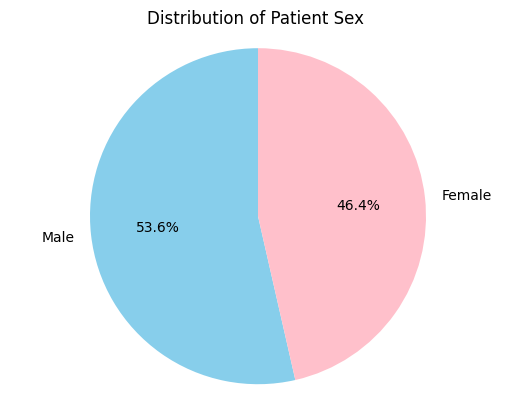

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

gender_counts = data['Patient Sex'].value_counts()
colors=['skyblue','pink']
plt.pie(gender_counts, labels=gender_counts.index, autopct='%1.1f%%', startangle=90,colors=colors)

plt.title('Distribution of Patient Sex ')

plt.axis('equal')
plt.show()

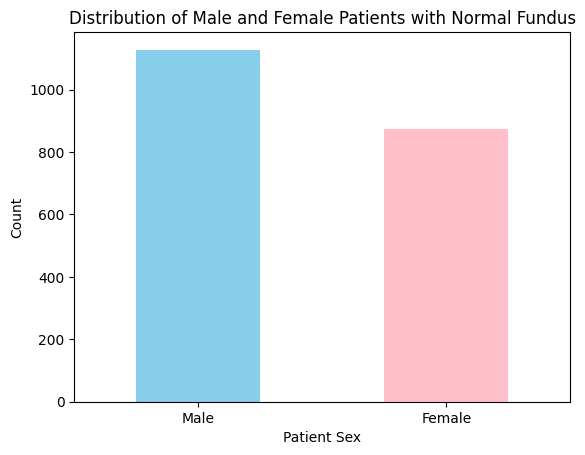

In [ ]:
filtered_data = data[(data['Left-Diagnostic Keywords'] == 'normal fundus') & (data['Right-Diagnostic Keywords'] == 'normal fundus')]

gender_counts = filtered_data['Patient Sex'].value_counts()
colors=['skyblue','pink']
gender_counts.plot(kind='bar', rot=0,color=colors)

plt.xlabel('Patient Sex')
plt.ylabel('Count')
plt.title('Distribution of Male and Female Patients with Normal Fundus')

plt.show()

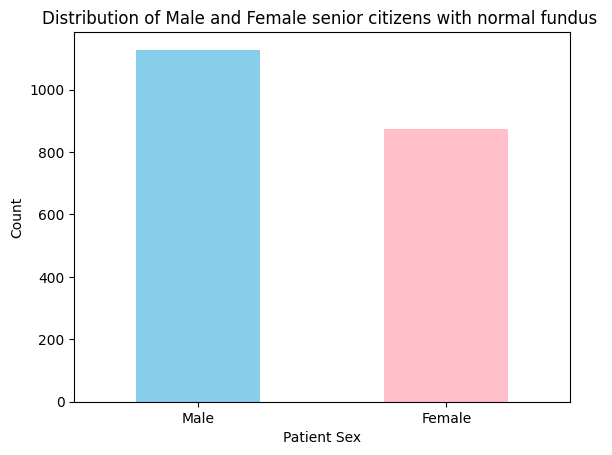

In [ ]:
senior_citizens = data[(data['Left-Diagnostic Keywords'] == 'normal fundus') & (data['Right-Diagnostic Keywords'] == 'normal fundus') &(data['Patient Age'] >= 65)]
colors=['skyblue','pink']
gender_counts.plot(kind='bar', rot=0,color=colors)

plt.xlabel('Patient Sex')
plt.ylabel('Count')
plt.title('Distribution of Male and Female senior citizens with normal fundus ')
plt.show()

In [ ]:
#data[data.O==1].head(20)  #drusen or epiretinal membrane

def process_dataset(data):
    #create 2 more columns labelling them whether right or left cataract
    data["left_cataract"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("cataract",x))
    data["right_cataract"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("cataract",x))

    data["LD"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("non proliferative retinopathy",x))
    data["RD"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("non proliferative retinopathy",x))

    data["LG"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("glaucoma",x))
    data["RG"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("glaucoma",x))

    data["LH"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("hypertensive",x))
    data["RH"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("hypertensive",x))

    data["LM"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("myopia",x))
    data["RM"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("myopia",x))

    data["LA"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("macular degeneration",x))
    data["RA"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("macular degeneration",x))

    data["LO"] = data["Left-Diagnostic Keywords"].apply(lambda x: has_condn("drusen",x))
    data["RO"] = data["Right-Diagnostic Keywords"].apply(lambda x: has_condn("drusen",x))

    #store the right/left cataract images ids in a array
    left_cataract_images = data.loc[(data.C ==1) & (data.left_cataract == 1)]["Left-Fundus"].values
    right_cataract_images = data.loc[(data.C == 1) & (data.right_cataract == 1)]["Right-Fundus"].values

    #store the left/right normal image ids in a array
    left_normal = data.loc[(data.C == 0) & (data["Left-Diagnostic Keywords"] == "normal fundus")]['Left-Fundus'].sample(350,random_state=42).values
    right_normal = data.loc[(data.C == 0) & (data["Right-Diagnostic Keywords"] == "normal fundus")]['Right-Fundus'].sample(350,random_state=42).values


    #store the left/right diabetes image ids
    left_diab = data.loc[(data.C == 0) & (data.LD == 1)]["Left-Fundus"].values
    right_diab = data.loc[(data.C == 0) & (data.RD == 1)]["Right-Fundus"].values

    #store the left/right glaucoma image ids
    left_glaucoma = data.loc[(data.C == 0) & (data.LG == 1)]["Left-Fundus"].values
    right_glaucoma = data.loc[(data.C == 0) & (data.RG == 1)]["Right-Fundus"].values

    #store the left/right diabetes image ids
    left_hyper = data.loc[(data.C == 0) & (data.LH == 1)]["Left-Fundus"].values
    right_hyper = data.loc[(data.C == 0) & (data.RH == 1)]["Right-Fundus"].values

    #store the left/right diabetes image ids
    left_myopia = data.loc[(data.C == 0) & (data.LM == 1)]["Left-Fundus"].values
    right_myopia = data.loc[(data.C == 0) & (data.RM == 1)]["Right-Fundus"].values

    #store the left/right diabetes image ids
    left_age = data.loc[(data.C == 0) & (data.LA == 1)]["Left-Fundus"].values
    right_age = data.loc[(data.C == 0) & (data.RA == 1)]["Right-Fundus"].values

    #store the left/right diabetes image ids
    left_other = data.loc[(data.C == 0) & (data.LO == 1)]["Left-Fundus"].values
    right_other = data.loc[(data.C == 0) & (data.RO == 1)]["Right-Fundus"].values

    normalones = np.concatenate((left_normal,right_normal),axis = 0);
    cataractones = np.concatenate((left_cataract_images,right_cataract_images),axis = 0);
    diabones = np.concatenate((left_diab,right_diab),axis = 0);
    glaucoma = np.concatenate((left_glaucoma,right_glaucoma),axis = 0);
    hyper = np.concatenate((left_hyper,right_hyper),axis = 0);
    myopia = np.concatenate((left_myopia,right_myopia),axis = 0);
    age = np.concatenate((left_age,right_age),axis=0);
    other = np.concatenate((left_other,right_other),axis = 0);

    return normalones,cataractones,diabones,glaucoma,hyper,myopia,age,other;

In [ ]:
normal , cataract , diab, glaucoma , hyper , myopia , age, other = process_dataset(data);

print("Dataset stats::")
print("Normal ::" , len(normal))
print("Cataract ::" , len(cataract))
print("Diabetes ::" , len(diab))
print("Glaucoma ::" , len(glaucoma))
print("Hypertension ::" , len(hyper))
print("Myopia ::" , len(myopia))
print("Age Issues ::" , len(age))
print("Other ::" , len(other))

Dataset stats::
Normal :: 700
Cataract :: 594
Diabetes :: 1818
Glaucoma :: 610
Hypertension :: 374
Myopia :: 479
Age Issues :: 551
Other :: 324


In [ ]:
 # prompt: over-sample the all the classes except Diabetes classes  and print the before and after len of every classes

from sklearn.utils import resample

# over-sample all the classes except Diabetes
normal_oversampled = resample(normal, replace=True, n_samples=len(diab), random_state=42)
cataract_oversampled = resample(cataract, replace=True, n_samples=len(diab), random_state=42)
glaucoma_oversampled = resample(glaucoma, replace=True, n_samples=len(diab), random_state=42)
hyper_oversampled = resample(hyper, replace=True, n_samples=len(diab), random_state=42)
myopia_oversampled = resample(myopia, replace=True, n_samples=len(diab), random_state=42)
age_oversampled = resample(age, replace=True, n_samples=len(diab), random_state=42)
other_oversampled = resample(other, replace=True, n_samples=len(diab), random_state=42)

# print the before and after len of every classes
print("Before over-sampling:")
print("Normal:", len(normal))
print("Cataract:", len(cataract))
print("Diabetes:", len(diab))
print("Glaucoma:", len(glaucoma))
print("Hypertension:", len(hyper))
print("Myopia:", len(myopia))
print("Age Issues:", len(age))
print("Other:", len(other))
print("\nAfter over-sampling:")
print("Normal:", len(normal_oversampled))
print("Cataract:", len(cataract_oversampled))
print("Diabetes:", len(diab))
print("Glaucoma:", len(glaucoma_oversampled))
print("Hypertension:", len(hyper_oversampled))
print("Myopia:", len(myopia_oversampled))
print("Age Issues:", len(age_oversampled))
print("Other:", len(other_oversampled))

Before over-sampling:
Normal: 700
Cataract: 594
Diabetes: 1818
Glaucoma: 610
Hypertension: 374
Myopia: 479
Age Issues: 551
Other: 324

After over-sampling:
Normal: 1818
Cataract: 1818
Diabetes: 1818
Glaucoma: 1818
Hypertension: 1818
Myopia: 1818
Age Issues: 1818
Other: 1818


In [ ]:
from tensorflow.keras.preprocessing.image import load_img,img_to_array
dataset_dir = "/content/preprocessed_images"
image_size=224
labels = []
dataset_train = []
dataset_valid = []
dataset_test = []

def dataset_generator(imagecategory , label):
    for img in tqdm(imagecategory):
        imgpath = os.path.join(dataset_dir,img);

        #now we try to read the image and resize it accordingly
        try:
            image = cv2.imread(imgpath,cv2.IMREAD_COLOR)
            image = cv2.resize(image,(image_size,image_size))
        except:
            continue;
        dataset.append([np.array(image),np.array(label)]);
    random.shuffle(dataset);

    return dataset;

In [ ]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.utils import resample

# Define a function to load and preprocess images
def load_and_preprocess_image(img_path, image_size):
    try:
        image = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if image is None:
            return None
        image = cv2.resize(image, (image_size, image_size))
        return image
    except Exception as e:
        print(f"Error processing image {img_path}: {e}")
        return None

# Define a function to generate dataset
def dataset_generator(image_category, label, image_size):
    dataset = []
    for img in tqdm(image_category):
        img_path = os.path.join(dataset_dir, img)
        image = load_and_preprocess_image(img_path, image_size)
        if image is not None:
            dataset.append([np.array(image), np.array(label)])
    return dataset

# Assuming dataset_dir and image_size are defined

# Split each class into training, validation, and test sets
normal_train, normal_test = train_test_split(normal, test_size=0.1, random_state=42)
normal_train, normal_val = train_test_split(normal_train, test_size=0.1, random_state=42)

cataract_train, cataract_test = train_test_split(cataract, test_size=0.1, random_state=42)
cataract_train, cataract_val = train_test_split(cataract_train, test_size=0.1, random_state=42)

glaucoma_train, glaucoma_test = train_test_split(glaucoma, test_size=0.1, random_state=42)
glaucoma_train, glaucoma_val = train_test_split(glaucoma_train, test_size=0.1, random_state=42)

diab_train, diab_test = train_test_split(diab, test_size=0.1, random_state=42)
diab_train, diab_val = train_test_split(diab_train, test_size=0.1, random_state=42)

hyper_train, hyper_test = train_test_split(hyper, test_size=0.1, random_state=42)
hyper_train, hyper_val = train_test_split(hyper_train, test_size=0.1, random_state=42)

myopia_train, myopia_test = train_test_split(myopia, test_size=0.1, random_state=42)
myopia_train, myopia_val = train_test_split(myopia_train, test_size=0.1, random_state=42)

age_train, age_test = train_test_split(age, test_size=0.1, random_state=42)
age_train, age_val = train_test_split(age_train, test_size=0.1, random_state=42)

other_train, other_test = train_test_split(other, test_size=0.1, random_state=42)
other_train, other_val = train_test_split(other_train, test_size=0.1, random_state=42)

# Perform oversampling on the training set
normal_train_oversampled = resample(normal_train, replace=True, n_samples=len(diab_train), random_state=42)
cataract_train_oversampled = resample(cataract_train, replace=True, n_samples=len(diab_train), random_state=42)
glaucoma_train_oversampled = resample(glaucoma_train, replace=True, n_samples=len(diab_train), random_state=42)
hyper_train_oversampled = resample(hyper_train, replace=True, n_samples=len(diab_train), random_state=42)
myopia_train_oversampled = resample(myopia_train, replace=True, n_samples=len(diab_train), random_state=42)
age_train_oversampled = resample(age_train, replace=True, n_samples=len(diab_train), random_state=42)
other_train_oversampled = resample(other_train, replace=True, n_samples=len(diab_train), random_state=42)

# Generate datasets
dataset_train = []
dataset_train += dataset_generator(normal_train_oversampled, 0, image_size)
dataset_train += dataset_generator(cataract_train_oversampled, 1, image_size)
dataset_train += dataset_generator(diab_train, 2, image_size)
dataset_train += dataset_generator(glaucoma_train_oversampled, 3, image_size)
dataset_train += dataset_generator(hyper_train_oversampled, 4, image_size)
dataset_train += dataset_generator(myopia_train_oversampled, 5, image_size)
dataset_train += dataset_generator(age_train_oversampled, 6, image_size)
dataset_train += dataset_generator(other_train_oversampled, 7, image_size)

dataset_valid = []
dataset_valid += dataset_generator(normal_val, 0, image_size)
dataset_valid += dataset_generator(cataract_val, 1, image_size)
dataset_valid += dataset_generator(diab_val, 2, image_size)
dataset_valid += dataset_generator(glaucoma_val, 3, image_size)
dataset_valid += dataset_generator(hyper_val, 4, image_size)
dataset_valid += dataset_generator(myopia_val, 5, image_size)
dataset_valid += dataset_generator(age_val, 6, image_size)
dataset_valid += dataset_generator(other_val, 7, image_size)

dataset_test = []
dataset_test += dataset_generator(normal_test, 0, image_size)
dataset_test += dataset_generator(cataract_test, 1, image_size)
dataset_test += dataset_generator(diab_test, 2, image_size)
dataset_test += dataset_generator(glaucoma_test, 3, image_size)
dataset_test += dataset_generator(hyper_test, 4, image_size)
dataset_test += dataset_generator(myopia_test, 5, image_size)
dataset_test += dataset_generator(age_test, 6, image_size)
dataset_test += dataset_generator(other_test, 7, image_size)

# Print the lengths of different sets
print("Before over-sampling:")
print("Training Set:", len(dataset_train))
print("Validation Set:", len(dataset_valid))
print("Test Set:", len(dataset_test))

# Proceed with your training process using dataset_train, dataset_valid, dataset_test as your datasets

100%|██████████| 33/33 [00:00<00:00, 407.12it/s]

Before over-sampling:
Training Set: 11648
Validation Set: 490
Test Set: 545


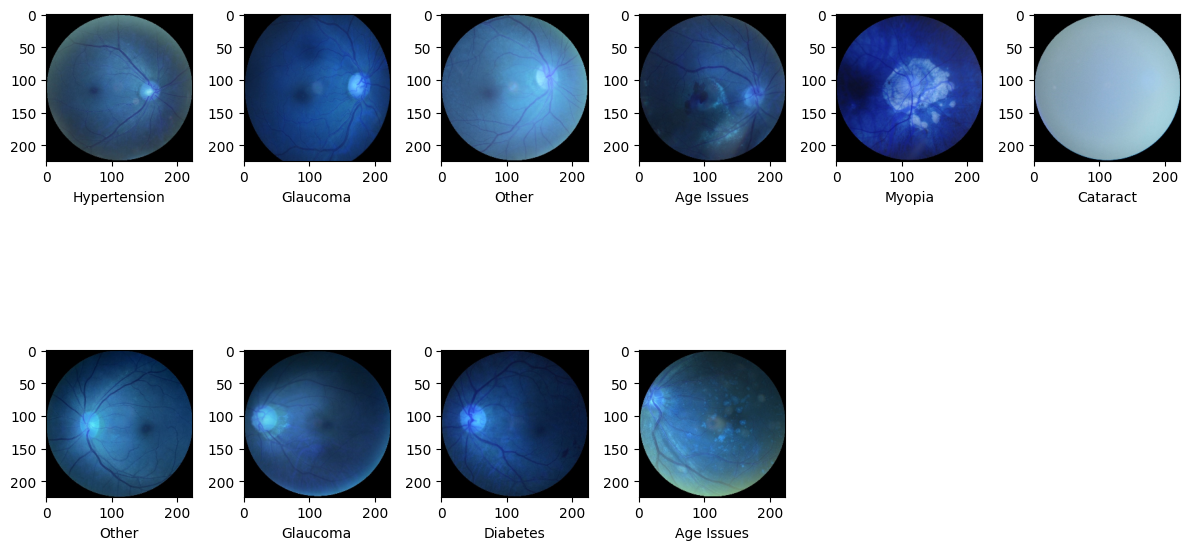

In [ ]:
plt.figure(figsize=(12,7))
for i in range(10):
    sample = random.choice(range(len(dataset_train)))
    image = dataset_train[sample][0]
    category = dataset_train[sample][1]

    if category== 0:
        label = "Normal"
    elif category == 1 :
        label = "Cataract"
    elif category == 2:
        label = "Diabetes"
    elif category == 3:
        label = "Glaucoma"
    elif category == 4:
        label = "Hypertension"
    elif category == 5:
        label = "Myopia"
    elif category == 6:
        label = "Age Issues"
    else:
        label = "Other"

    plt.subplot(2,6,i+1)
    plt.imshow(image)
    plt.xlabel(label)
plt.tight_layout()

In [ ]:
# prompt: get the size of the train of each class in the datsets and thier names a

import numpy as np

# Extract y_train from dataset_train
y_train = [item[1] for item in dataset_train]  # Extract category values

# Convert y_train to a NumPy array
y_train = np.array(y_train)  # Convert y_train to NumPy array for compatibility with np.where

# Get the size of the train of each class in the datsets and their names
class_names = ['Normal', 'Cataract', 'Diabetes', 'Glaucoma', 'Hypertension', 'Myopia', 'Age Issues', 'Other']
class_sizes = {}
for i in range(len(class_names)):
  class_sizes[class_names[i]] = len(np.where(y_train == i)[0])

# Print the class names and their sizes
for class_name, class_size in class_sizes.items():
  print(f"{class_name}: {class_size}")

Normal: 1472
Cataract: 1448
Diabetes: 1447
Glaucoma: 1464
Hypertension: 1472
Myopia: 1450
Age Issues: 1472
Other: 1423


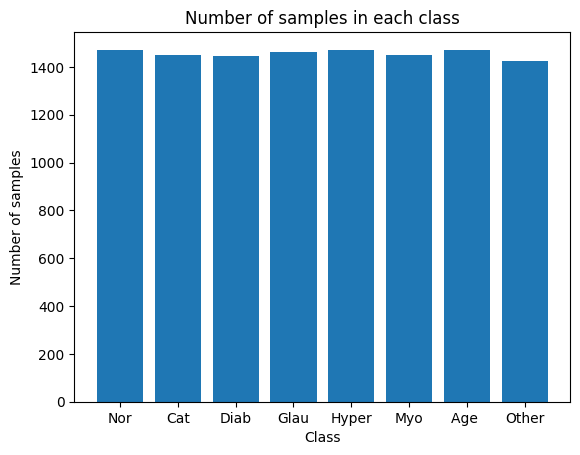

In [ ]:
# prompt: plot the number of samples in each class and it names

import matplotlib.pyplot as plt

# Get the class names and sizes
class_names = ['Nor', 'Cat', 'Diab', 'Glau', 'Hyper', 'Myo', 'Age ', 'Other']
class_sizes = {}
for i in range(len(class_names)):
  class_sizes[class_names[i]] = len(np.where(y_train == i)[0])

# Create a bar chart
plt.bar(class_names, class_sizes.values())
plt.xlabel("Class")
plt.ylabel("Number of samples")
plt.title("Number of samples in each class")
plt.show()

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals

# Import libraries
import json
import os
import pickle
import random
import time

# Ignore warnings
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch

# PyTorch model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from skimage import io, transform

In [ ]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [ ]:
!nvidia-smi

Fri Apr 11 00:53:59 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             12W /   70W |       2MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
device_name = "cuda" if torch.cuda.is_available() else "cpu"
device = torch.device(device_name)

print(device_name)

cuda


In [ ]:
def save_checkpoint(state, is_best, filename='/kaggle/working/bt_resnet50_ckpt_v2.pth.tar'):
    torch.save(state, filename)

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import tensorflow as tf  # Import TensorFlow here



# Instantiate ResNet50 model
resnet_model = ResNet50(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))

# Set all parameters as trainable
for layer in resnet_model.layers:
    layer.trainable = True

# Redefine fc layer for the classification problem
def create_model(l2_strength):
    resnet_model_top = models.Sequential([
        layers.Flatten(),
        layers.Dense(2048, activation="relu"),
        layers.Dropout(0.4),
        layers.Dense(2048, activation="relu"),   # Fixed import here
        layers.Dropout(0.4),
        layers.Dense(8, activation="softmax")
    ])


    # Concatenate ResNet50 base model with the new top layers
    model = models.Sequential([
        resnet_model,
        resnet_model_top
    ])

    return model

# Define data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=40,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.3,  # randomly shift images vertically (fraction of total height)
    shear_range=0.2,  # randomly apply shear transformation
    zoom_range=0.2,  # randomly zoom in/out on images
    brightness_range=[0.4, 0.9],  # randomly adjust brightness of images
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False,  # do not flip images vertically
    data_format='channels_last',  # data format
    fill_mode='constant'  # fill mode for newly created pixels
)
# # Compute class weights manually
# class_counts = np.bincount(y_train)
# total_samples = np.sum(class_counts)
# class_weights = total_samples / (len(class_counts) * class_counts)

# Convert class weights to dictionary format
#class_weight = dict(enumerate(class_weights))


# Compile the model
def compile_model(model, l2_strength):
    model.compile(optimizer=SGD(learning_rate=3e-4, momentum=0.9),
                  loss="categorical_crossentropy",
                  metrics=['accuracy'])

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='loss',
    patience=10,
    restore_best_weights=True
)

# Prepare training and validation data
x_train = np.array([item[0] for item in dataset_train])
y_train = np.array([item[1] for item in dataset_train])
x_valid = np.array([item[0] for item in dataset_valid])
y_valid = np.array([item[1] for item in dataset_valid])

# One-hot encode the labels if necessary
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train, num_classes=8)  # Assuming 8 classes
y_valid_cat = to_categorical(y_valid, num_classes=8)

# Train the model with data augmentation and class weights for each L2 strength
l2_strengths = [0.001]
for l2_strength in l2_strengths:
    model = create_model(l2_strength)
    compile_model(model, l2_strength)
    history = model.fit(x_train, y_train_cat,
                    batch_size=32,
                    epochs=10,
                    validation_data=(x_valid, y_valid_cat),
#                      class_weight=class_weight,
                    callbacks=[early_stopping_callback])


# Train the model with data augmentation and class weights for each L2 strength
#l2_strengths = [0.001]
#for l2_strength in l2_strengths:
#    model = create_model(l2_strength)
#    compile_model(model, l2_strength)
#    history = model.fit(x_train, y_train_cat,
#                    batch_size=32,
#                    epochs=10,
#                    validation_data=(x_valid, y_valid_cat),
## #                      class_weight=class_weight,
#                    callbacks=[early_stopping_callback])

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 169s 341ms/step - accuracy: 0.4890 - loss: 1.7731 - val_accuracy: 0.6551 - val_loss: 0.9266
Epoch 2/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 172s 322ms/step - accuracy: 0.8722 - loss: 0.3949 - val_accuracy: 0.7714 - val_loss: 0.7251
Epoch 3/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 141s 318ms/step - accuracy: 0.9355 - loss: 0.2143 - val_accuracy: 0.7755 - val_loss: 0.7532
Epoch 4/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 141s 317ms/step - accuracy: 0.9538 - loss: 0.1622 - val_accuracy: 0.8204 - val_loss: 0.7100
Epoch 5/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 115s 315ms/step - accuracy: 0.9657 - loss: 0.1221 - val_accuracy: 0.8306 - val_loss: 0.6755
Epoch 6/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 115s 315ms/step - accuracy: 0.9675 - loss: 0.1051 - val_accuracy: 0.7796 - val_loss: 0.8054
Epoch 7/10
364/364 ━━━━━━━━━━━━━━━━━━━━ 143s 318ms/step - accuracy: 0.9685 - loss: 0.1039 - val_accuracy: 0.8429 - val_loss: 0.6923
Epoch 8/10
364/364 ━━━━━━

In [ ]:
model.save("my_trained_model.h5")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
model.save("/content/drive/MyDrive/F5_project/my_trained_model.h5")

Mounted at /content/drive


In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras import models
from tensorflow.keras import layers

# Instantiate ResNet50 model
resnet_model = ResNet50(weights="imagenet", include_top=False, input_shape=(image_size, image_size, 3))

# Set all parameters as trainable
for layer in resnet_model.layers:
    layer.trainable = True

# Get the number of input features for the fc layer
n_inputs = resnet_model.output_shape[1]

# Redefine fc layer for the classification problem
resnet_model_top = models.Sequential([
    layers.Flatten(),
    layers.Dense(2048, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(2048, activation="relu"),
    layers.Dropout(0.4),
    layers.Dense(8, activation="softmax")
])

# Concatenate ResNet50 base model with the new top layers
model = models.Sequential([
    resnet_model,
    resnet_model_top
])

# Print model summary

model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_2 (Sequential)       │ (None, 8)              │   209,735,688 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 233,323,400 (890.06 MB)

 Trainable params: 233,270,280 (889.86 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Compile the model
model.compile(optimizer=SGD(learning_rate=3e-4, momentum=0.9),
              loss="categorical_crossentropy",
              metrics=['accuracy'])

In [ ]:
from sklearn.utils.class_weight import compute_class_weight

# Define data augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
    shear_range=0.2,  # randomly apply shear transformation
    zoom_range=0.2,  # randomly zoom in/out on images
    horizontal_flip=True,  # randomly flip images horizontally
    vertical_flip=False  # randomly flip images vertically
)

# Fit the data augmentation generator on the training data
datagen.fit(x_train)

# Compute class weights manually
class_counts = np.bincount(y_train)
total_samples = np.sum(class_counts)
class_weights = total_samples / (len(class_counts) * class_counts)

# # Convert class weights to dictionary format
class_weight = dict(enumerate(class_weights))


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stopping_callback = EarlyStopping(
    monitor='loss',   # Monitor training loss
    patience=10,       # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights to the best epoch
)

In [ ]:
# Train the model with data augmentation and class weights
history = model.fit(datagen.flow(x_train, y_train_cat, batch_size=32),
                    steps_per_epoch=len(x_train) / 32,
                    epochs=200,  # Set a large number of epochs
                    validation_data=(x_test, y_test_cat),
                    class_weight=class_weight,
                     callbacks=[early_stopping_callback])

In [ ]:
x_test = np.array([item[0] for item in dataset_test])
y_test = np.array([item[1] for item in dataset_test])
y_test_cat = to_categorical(y_test, num_classes=8)


In [ ]:
loss, accuracy = model.evaluate(x_test, y_test_cat)
print("Accuracy:", accuracy)

18/18 ━━━━━━━━━━━━━━━━━━━━ 6s 341ms/step - accuracy: 0.7350 - loss: 0.8798
Accuracy: 0.800000011920929


In [ ]:
loss,accuracy = model.evaluate(x_test,y_test_cat)
print("Accuracy:",accuracy)

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 82ms/step - accuracy: 0.7350 - loss: 0.8798
Accuracy: 0.800000011920929


In [ ]:
loss, accuracy = model.evaluate(x_test, y_test_cat)
print("Test Accuracy:", accuracy)

val_loss, val_accuracy = model.evaluate(x_valid, y_valid_cat)
print("Validation Accuracy:", val_accuracy)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.7350 - loss: 0.8798
Test Accuracy: 0.800000011920929
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - accuracy: 0.7816 - loss: 0.8945
Validation Accuracy: 0.8306122422218323


In [ ]:
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
y_pred = np.array((model.predict(x_test) > 0.5).astype("int32"))

y_pred = []
for i in model.predict(x_test):
    y_pred.append(np.argmax(np.array(i)).astype("int32"))

print(y_pred)

18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 358ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 80ms/step
[np.int32(3), np.int32(2), np.int32(0), np.int32(2), np.int32(0), np.int32(1), np.int32(2), np.int32(0), np.int32(0), np.int32(6), np.int32(2), np.int32(0), np.int32(2), np.int32(0), np.int32(4), np.int32(0), np.int32(2), np.int32(7), np.int32(3), np.int32(0), np.int32(2), np.int32(2), np.int32(0), np.int32(3), np.int32(0), np.int32(2), np.int32(0), np.int32(0), np.int32(0), np.int32(2), np.int32(3), np.int32(2), np.int32(3), np.int32(4), np.int32(0), np.int32(4), np.int32(0), np.int32(3), np.int32(6), np.int32(2), np.int32(0), np.int32(0), np.int32(0), np.int32(0), np.int32(2), np.int32(0), np.int32(2), np.int32(0), np.int32(0), np.int32(0), np.int32(0), np.int32(0), np.int32(0), np.int32(2), np.int32(0), np.int32(2), np.int32(0), np.int32(2), np.int32(0), np.int32(2), np.int32(0), np.int32(1), np.int32(0), np.int32(2), np.int32(2), np.int32(0), np.int32(3), np.int32(0), np.int32(2), np.int32(0), np.int3

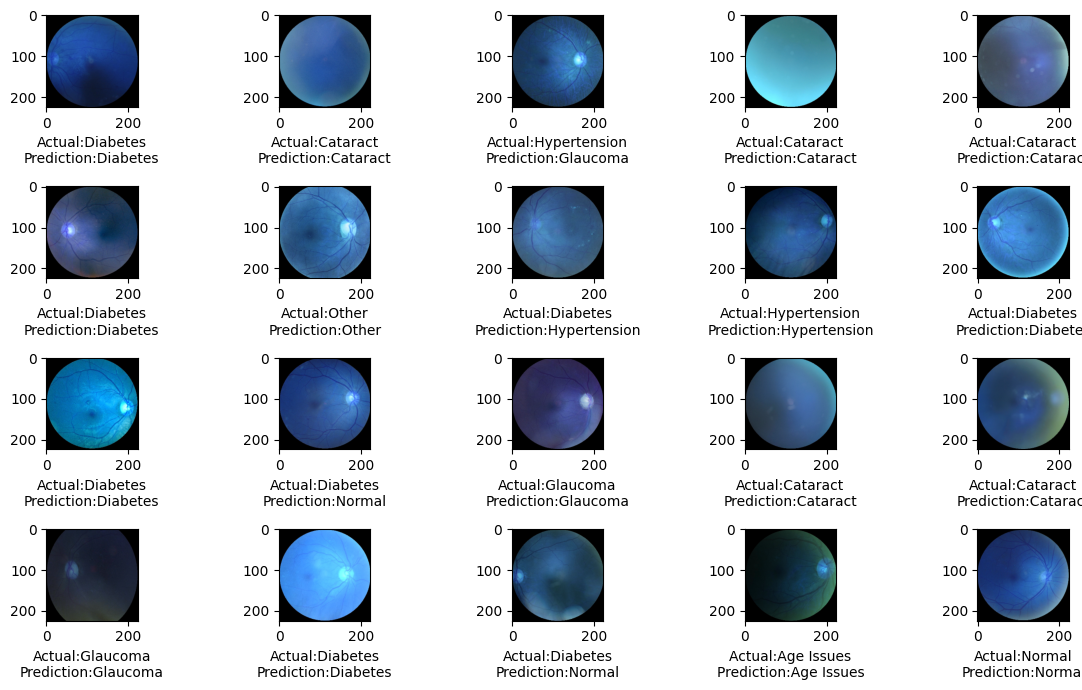

In [ ]:
plt.figure(figsize=(12,7))
for i in range(20):
    sample = random.choice(range(len(x_test)))
    image = x_test[sample]
    category = y_test[sample]
    pred_category = y_pred[sample]

    if category== 0:
        label = "Normal"
    elif category == 1 :
        label = "Cataract"
    elif category == 2:
        label = "Diabetes"
    elif category == 3:
        label = "Glaucoma"
    elif category == 4:
        label = "Hypertension"
    elif category == 5:
        label = "Myopia"
    elif category == 6:
        label = "Age Issues"
    else:
        label = "Other"

    if pred_category== 0:
        pred_label = "Normal"
    elif pred_category == 1 :
        pred_label = "Cataract"
    elif pred_category == 2:
        pred_label = "Diabetes"
    elif pred_category == 3:
        pred_label = "Glaucoma"
    elif pred_category == 4:
        pred_label = "Hypertension"
    elif pred_category == 5:
        pred_label = "Myopia"
    elif pred_category == 6:
        pred_label = "Age Issues"
    else:
        pred_label = "Other"

    plt.subplot(4,5,i+1)
    plt.imshow(image)
    plt.xlabel("Actual:{}\nPrediction:{}".format(label,pred_label))
plt.tight_layout()

In [ ]:
# prompt: Calculate F1-score and precision and Recall for each class

from sklearn.metrics import classification_report

# Assuming y_test and y_pred are defined as in the provided code
print(classification_report(y_test, y_pred, target_names=['Normal', 'Cataract', 'Diabetes', 'Glaucoma', 'Hypertension', 'Myopia', 'Age Issues', 'Other']))


In [ ]:
model.save("my_trained_model.h5")